<a href="https://colab.research.google.com/github/voquangtuong/AAA_drought_prediction/blob/main/T4_tunner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Set Output folder

In [2]:
import os
os.chdir('/content/drive/MyDrive/dynamic/T4_old_tnner1')
outs=['save_model_T4','save_pickle','table_T4','fig_T4']
for out in outs:
  if not os.path.exists(out):
    os.makedirs(out)

# Import Libraries

In [3]:
# Run functions
%run customize_functions.ipynb

# Load data and initial paramaters

In [4]:

# Load du lieu
# load data obs
with open('input_pickles'+'/'+'PRS3_NDI3_59new.pkl', 'rb') as f1:
    # compressed_file = bz2.BZ2File(f, 'r')
    PRS3_NDI3_59 = pickle.load(f1)

###### CHOSEN STATION INPUT, LEAD TIME PREDICTION###############################    
# kiem tra cho ganghwa
k=29
n_in0=3
n_out0=1
m=n_out0 # tinh cho buoc 0
df0=PRS3_NDI3_59[k] # 1968-2020
# chia du lieu cho 12 lay 6 phan cho train, 3 phan cho val, 3 phan cho test
df1=df0.iloc[:(2016-1968+1)*12,:]
# df1=df0 # du bao het
# =============================================================================

# =============================================================================

df2=series_to_supervised_df(df1,n_in0,n_out0)

# =============================================================================
# =============================================================================
#     remove values PRS  at fure prediction
# var3(t),var2(t),var1(t) have to remove
list_drops=[np.arange(2,5)*-1,np.arange(2,9)*-1,np.arange(2,13)*-1]
list_drops1=[[],[],[]]
list_drops1a=[[-5,-9,-13],[-5,-9,-13,-17],[-5,-9,-13,-17,-21]]


# =============================================================================
df3=df2.drop(df2.columns[[list_drops1[n_out0-1]]],axis=1)
df4=df3.drop(df3.columns[[list_drops1a[n_out0-1]]],axis=1)

# =============================================================================
# Chia du lieu theo ti le 6:3:3
n_train=int(df4.shape[0]*0.6)
n_val=int(df4.shape[0]*0.8)-n_train
n_test=df4.shape[0]-n_val-n_train

train_df=df4.iloc[0:n_train,:]
val_df=df4.iloc[n_train:n_train+n_val,:]
test_df=df4.iloc[n_train+n_val:,:]
# print(train_df.shape,val_df.shape,test_df.shape)
x_train,y_train0=train_df.iloc[:,:-1].values,train_df.iloc[:,-1].values
# lay chinh no du bao no luon
# x_train,y_train0=train_df.iloc[:,:].values,train_df.iloc[:,-1].values # KIEM TRA DU BAO CHO CHINH NO
y_train=y_train0.reshape(y_train0.shape[0],1)
# print(x_train.shape,y_train.shape)

x_val,y_val0=val_df.iloc[:,:-1].values,val_df.iloc[:,-1].values
# x_val,y_val0=val_df.iloc[:,:].values,val_df.iloc[:,-1].values #  KIEM TRA DU BAO CHO CHINH NO
y_val=y_val0.reshape(y_val0.shape[0],1)
# print(x_val.shape,y_val.shape)

x_test,y_test0=test_df.iloc[:,:-1].values,test_df.iloc[:,-1].values

# x_test,y_test0=test_df.iloc[:,:].values,test_df.iloc[:,-1].values # KIEM TRA DU BAO CHO CHINH NO
y_test=y_test0.reshape(y_test0.shape[0],1)
# print(x_test.shape,y_test.shape)

# =============================================================================


# =============================================================================
# Scale data
# tao 2 scaler rieng cho X, Y de invert cho de
scaler_x = MinMaxScaler(feature_range=(0.01, 0.99))
scaler_y = MinMaxScaler(feature_range=(0.01, 0.99))

x_train_scale = scaler_x.fit_transform(x_train)
y_train_scale = scaler_y.fit_transform(y_train)

# fit scale cua train cho val va test
x_val_scale=scaler_x.transform(x_val)
y_val_scale=scaler_y.transform(y_val)

x_test_scale=scaler_x.transform(x_test)
y_test_scale=scaler_y.transform(y_test)
n_features=1
train_X = x_train_scale.reshape((x_train_scale.shape[0], x_train_scale.shape[1], n_features))
val_X = x_val_scale.reshape((x_val_scale.shape[0], x_val_scale.shape[1], n_features))
test_X = x_test_scale.reshape((x_test_scale.shape[0], x_test_scale.shape[1], n_features))



/usr/local/lib/python3.7/dist-packages/pandas/core/indexes/base.py:4114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


# Define model and setup training, save models


In [5]:

# =============================================================================

# =============================================================================
# =============================================================================
# Define model
model = Sequential()
model.add(LSTM(32, activation='relu', return_sequences=False, input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(Bidirectional(LSTM(32, activation='relu')))
model.add(Dense(1))
# =============================================================================
opt = Adam(learning_rate = 0.001,  beta_1=0.9, beta_2=0.999, epsilon=1e-07,clipnorm = 0.999)
model.compile(optimizer=opt, loss='mse')
callbacks_list = [
keras.callbacks.EarlyStopping(
monitor="val_loss",
patience=600,
mode="min",
),
keras.callbacks.ModelCheckpoint(
filepath=outs[0]+"/"+str(k)+"lead"+str(m)+"best_stop.keras", # cong them buoc thoi gian
monitor="val_loss",
save_best_only=True,
)
]

# 
# Fit model

history1=model.fit(train_X,
          y_train_scale,
epochs=800,
callbacks=callbacks_list,
validation_data=(val_X,y_val_scale))


Epoch 1/800
11/11 [==============================] - 3s 83ms/step - loss: 0.1988 - val_loss: 0.1747
Epoch 2/800
11/11 [==============================] - 0s 14ms/step - loss: 0.1197 - val_loss: 0.0897
Epoch 3/800
11/11 [==============================] - 0s 11ms/step - loss: 0.0557 - val_loss: 0.0378
Epoch 4/800
11/11 [==============================] - 0s 12ms/step - loss: 0.0387 - val_loss: 0.0372
Epoch 5/800
11/11 [==============================] - 0s 12ms/step - loss: 0.0355 - val_loss: 0.0354
Epoch 6/800
11/11 [==============================] - 0s 12ms/step - loss: 0.0342 - val_loss: 0.0335
Epoch 7/800
11/11 [==============================] - 0s 12ms/step - loss: 0.0335 - val_loss: 0.0331
Epoch 8/800
11/11 [==============================] - 0s 13ms/step - loss: 0.0330 - val_loss: 0.0326
Epoch 9/800
11/11 [==============================] - 0s 12ms/step - loss: 0.0327 - val_loss: 0.0320
Epoch 10/800
11/11 [==============================] - 0s 12ms/step - loss: 0.0322 - val_loss: 0.0313

# Load results

In [6]:

# LOAD KET QUA TOT NHAT
# =============================================================================
# Load results
loaded_model=load_model(outs[0]+"/"+str(k)+"lead"+str(m)+"best_stop.keras")
print("Loaded model from disk")


Loaded model from disk


# Draw graphics

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


[786] [0.00595646]


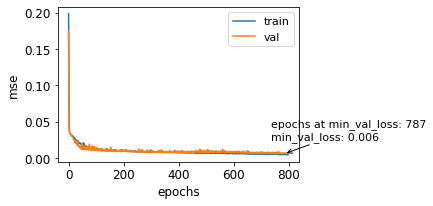

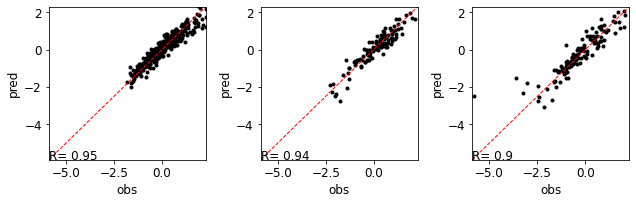

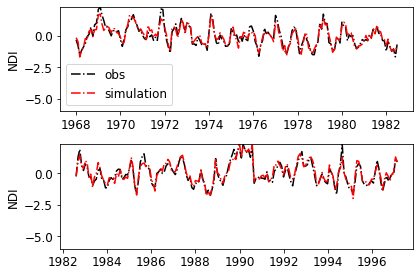

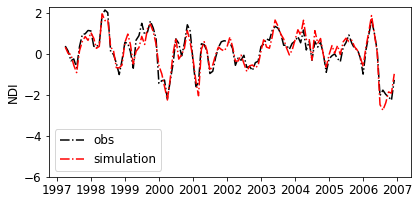

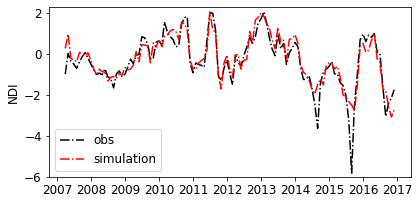

In [7]:

# =============================================================================
# DANH GIA
# =============================================================================
# TONG KET 
# DRAW LOSS CURVE
#Check the Loss curve
fig,ax=plt.subplots(figsize=(6,3))
plt.rcParams.update({'font.size': 11})
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
# Draw the minimum epochs 
df_val_loss=pd.DataFrame({'val_loss':history1.history['val_loss']})
# print(df_val_loss)
idxmin=df_val_loss[['val_loss']].idxmin().values
val_loss_min_values=df_val_loss.loc[idxmin,:].values.flatten()
print(idxmin,val_loss_min_values)
plt.annotate('epochs at min_val_loss: '+str(idxmin[0]+1)+'\n'+'min_val_loss: '+str(np.round(val_loss_min_values[0],3)),
             xy=(idxmin,val_loss_min_values), xycoords='data',
            xytext=(idxmin-50, val_loss_min_values+0.02), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )

plt.legend(['train','val'])
plt.xlabel('epochs')
plt.ylabel('mse')
# plt.title('learning rate of 1 month leadtime prdiction')
plt.tight_layout()
plt.savefig(outs[3]+'/'+str(k)+'loss_curve_T3'+str(m)+'.jpeg',dpi=300)
plt.show(fig)
plt.close(fig)
###################################################################################
#----------------------Important !!!!-----------------------#
pred = loaded_model.predict(train_X)  #(predicted)  
obs  = y_train_scale               #(obs) 
#-----------------------------------------------------------#

#----------------------reverse scaling------------------------------#
#For training period
y_hat_rescaled  = scaler_y.inverse_transform(pred) #prediction value
y_rescaled = scaler_y.inverse_transform(obs)         #observed value

#Inverse scaled --> pred, obs  
pred = y_hat_rescaled
obs = y_rescaled

# pred1, obs1: pred train, obs train
pred1=pred
obs1=obs

##########################################################
# Validation
pred = loaded_model.predict(val_X)  #(pred)  
obs  = y_val_scale                 #(obs) 
#-----------------------------------------------------------#

#----------------------reverse scaling------------------------------#
#For training period
y_hat_rescaled  = scaler_y.inverse_transform(pred) #prediction value
y_rescaled = scaler_y.inverse_transform(obs)         #observed value

#Inverse scaled --> pred, obs  
pred = y_hat_rescaled
obs = y_rescaled

# pred1, obs1: pred val, obs val
pred2=pred
obs2=obs

################################################################
pred = loaded_model.predict(test_X)  #(pred)  
obs  = y_test_scale                 #(obs) 
#-----------------------------------------------------------#

#----------------------reverse scaling------------------------------#
#For training period
y_hat_rescaled  = scaler_y.inverse_transform(pred) #prediction value
y_rescaled = scaler_y.inverse_transform(obs)         #observed value

#Inverse scaled --> pred, obs  
pred = y_hat_rescaled
obs = y_rescaled

# pred1, obs1: pred val, obs val
pred3=pred
obs3=obs
#--------------------------------------------------------------------#

# TOM LAI
list_con=list()
df_train=pd.DataFrame({'obs':obs1.flatten(),'pred':pred1.flatten()})
list_con.append(df_train)
df_val=pd.DataFrame({'obs':obs2.flatten(),'pred':pred2.flatten()})
list_con.append(df_val)
df_test=pd.DataFrame({'obs':obs3.flatten(),'pred':pred3.flatten()})
list_con.append(df_test)
# =============================================================================
# SAVE RESULTS
# =============================================================================
with open(outs[1]+'/'+str(k)+'lead'+str(m)+'T4_lag3.pkl', 'wb') as f: # khong nen
  # compressed_file = bz2.BZ2File(f, 'w')
  pickle.dump(list_con, f)

#####
## mo kiem tra lai
with open(outs[1]+'/'+str(k)+'lead'+str(m)+'T4_lag3.pkl', 'rb') as f: # khong nen
    # compressed_file = bz2.BZ2File(f, 'r')
    load_list_con = pickle.load(f)
# 0,1,2 tuong ung voi train, val, test
# pearson,dotincay=pearsonr(load_list_con[1]['obs'],load_list_con[1]['pred'])
# print('cc of val: '+str(pearson))
# =============================================================================
# VE HINH
# =============================================================================
# HINH  SCATTER
# Ve hinh statter plot cua training, validation and testing

# scale plot M1


axes=[131,132,133]
obs_all=[obs1,obs2,obs3]
pred_all=[pred1,pred2,pred3]
# lead_time=0
names_phases=['training','validation','testing']
for lead_time in range(1):
  fig,ax=plt.subplots(figsize=(9,3))
  plt.rcParams.update({'font.size': 12})
# lead_time=2
  for phase in range(3):
  # for lead_time in range(3):

    plt.subplot(axes[phase])
    pearson,dotincay=pearsonr(load_list_con[phase]['obs'],load_list_con[phase]['pred'])
    r2_vanila_1m =pearson
    plt.rcParams.update({'font.size': 12})
    
    min_values=-5.9
    max_values=2.29

    plt.xlim(min_values,max_values)
    plt.ylim(min_values,max_values)

    plt.scatter(x=load_list_con[phase]['obs'],
                y=load_list_con[phase]['pred'],
                s=None,
                c='k', 
                marker='.', 
                cmap=None,
                norm=None,
                vmin=None, 
                vmax=None,
                alpha=None,            
                linewidths=None,
                edgecolors=None,plotnonfinite=False,data=None)

    # ve duong 45
    # plt.legend(['NDI'])
    plt.xlabel('obs')
    if lead_time==0:
      plt.ylabel('pred')
    # if lead_time==1:
    # plt.title('M1S4prs_prs '+names_phases[m])
    # add_identity(ax, color='r', ls='--')
    plt.text(min_values,min_values,'R= '+str(round(r2_vanila_1m,2)))
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle='--', color='r', lw=1, scalex=False, scaley=False)

    plt.tight_layout()

  plt.savefig(outs[3]+'/'+str(k)+'scatter_T3'+str(m)+'.jpeg',dpi=300)
  plt.show()
  plt.close()
# =============================================================================
#VE HINH TIME SERIES
# =============================================================================
  
  # Ve TRAIN ***************************************************************
# Time series cua train
#Graph
months=['1month','2months','3months']
for lead_time in range(1):
  fig,ax=plt.subplots(figsize=(6,4))
  plt.subplot(211)
  plt.ylim([-6.0,2.3])
  plt.rcParams.update({'font.size': 12})
 
  vector_date=pd.date_range(start='1968-01',periods=df1.shape[0],freq='MS')
  plt.plot(vector_date[0+lead_time:lead_time+int(obs1.shape[0]*0.5)],obs1[0:int(obs1.shape[0]*0.5),lead_time],'k-.')
  plt.plot(vector_date[0+lead_time:lead_time+int(obs1.shape[0]*0.5)],pred1[0:int(obs1.shape[0]*0.5),lead_time],'r-.')

  plt.legend(['obs','simulation'])

  plt.ylabel('NDI')
  # plt.title('Time series '+'1 month' +' lead time prediction at trainning')
  plt.tight_layout()

  plt.subplot(212)
  plt.ylim([-6.0,2.3])
  plt.rcParams.update({'font.size': 12})
  
  plt.plot(vector_date[lead_time+int(obs1.shape[0]*0.5):lead_time+int(obs1.shape[0]*1)],obs1[int(obs1.shape[0]*0.5):int(obs1.shape[0]*1),lead_time],'k-.')
  plt.plot(vector_date[lead_time+int(obs1.shape[0]*0.5):lead_time+int(obs1.shape[0]*1)],pred1[int(pred1.shape[0]*0.5):int(pred1.shape[0]*1),lead_time],'r-.')
  plt.ylabel('NDI')
  plt.tight_layout()

plt.savefig(outs[3]+'/'+str(k)+'train_time_T3'+str(m)+'.jpeg',dpi=300)
plt.show()
plt.close()
############ VAL **************************************************************
# Time series cua val
#Graph
months=['1month','2months','3months']
for lead_time in range(1):
  fig,ax=plt.subplots(figsize=(6,3))
  plt.subplot(111)
  plt.rcParams.update({'font.size': 12})
  plt.ylim([-6.0,2.3])
  plt.plot(vector_date[n_train+lead_time:n_train+lead_time+obs2.shape[0]],obs2[:,lead_time],'k-.')
  plt.plot(vector_date[n_train+lead_time:n_train+lead_time+obs2.shape[0]],pred2[:,lead_time],'r-.')
  plt.legend(['obs','simulation'])
  plt.ylabel('NDI')
  plt.tight_layout()

  plt.savefig(outs[3]+'/'+str(k)+'val_time_T3'+str(m)+'.jpeg',dpi=300)
  plt.show()
  plt.close()

  # TEST*************************************************************************
  
#Graph
months=['1month','2months','3months']
for lead_time in range(1):
  fig,ax=plt.subplots(figsize=(6,3))
  plt.subplot(111)
  plt.rcParams.update({'font.size': 12})
  plt.ylim([-6.0,2.3])
  vector_date_test=vector_date[-24:]
  plt.plot(vector_date[-n_test:],obs3[:,lead_time],'k-.')
  plt.plot(vector_date[-n_test:],pred3[:,lead_time],'r-.')
    # plt.xticks(['2015-01','2015-06','2015-12','2016-12'])
  plt.legend(['obs','simulation'])

  plt.ylabel('NDI')
  # plt.title('Time series '+'1month' +' lead time prediction at testing')
  plt.tight_layout() 

  plt.savefig(outs[3]+'/'+str(k)+'test_time_T4'+str(m)+'.jpeg',dpi=300)
  plt.show()
  plt.close()
# =============================================================================
